In [ ]:
## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1048710776_bb5b0a5c7c']

['a couple of several people sitting on a ledge overlooking the beach',
 'A group of people sit on a wall at the beach .',
 'A group of teens sit on a wall by a beach .',
 'Crowd of people at the beach .',
 'Several young people sitting on a rail above a crowded beach .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1048710776_bb5b0a5c7c']

['startseq couple of several people sitting on ledge overlooking the beach endseq',
 'startseq group of people sit on wall at the beach endseq',
 'startseq group of teens sit on wall by beach endseq',
 'startseq crowd of people at the beach endseq',
 'startseq several young people sitting on rail above crowded beach endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[11:20]

['startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq',
 'startseq man lays on bench while his dog sits by him endseq',
 'startseq man lays on the bench to which white dog is also tied endseq',
 'startseq man sleeping on bench outside with white and black dog sitting next to him endseq',
 'startseq shirtless man lies on park bench with his dog endseq',
 'startseq man laying on bench holding leash of dog sitting on ground endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 256)      2172160     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

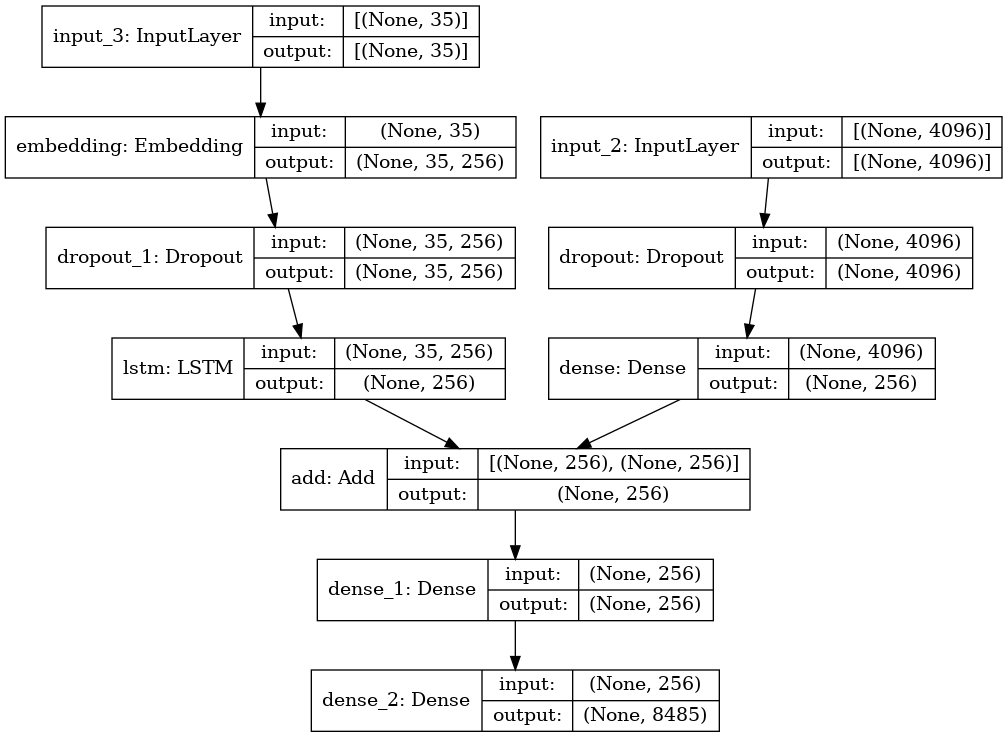

In [23]:
# plot the model
plot_model(model, to_file ='model.png', show_shapes=True)

227/227 [==============================] - 44s 195ms/step - loss: 2.0661


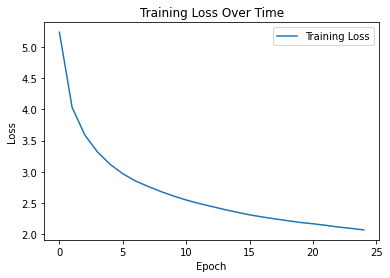

In [24]:
# train the model

import matplotlib.pyplot as plt

# Define training parameters
epochs = 25
batch_size = 32
steps_per_epoch = len(train) // batch_size

# Initialize lists to store training history
loss_history = []

# Train the model
for epoch in range(epochs):
    # Create a data generator for this epoch
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # Train for one epoch
    history = model.fit(generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)
    
    # Append the loss to the loss history
    loss_history.append(history.history['loss'])

# Plot training curves
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [26]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.526310
BLEU-2: 0.302307
BLEU-3: 0.187144
BLEU-4: 0.109540


In [76]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(' '.join(a[0]), ' '.join(p)) for a, p in zip(actual, predicted)]
rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]
rouge2_scores = [score['rouge2'].fmeasure for score in rouge_scores]
rougeL_scores = [score['rougeL'].fmeasure for score in rouge_scores]
print("ROUGE-1: %f" % (sum(rouge1_scores) / len(rouge1_scores)))
print("ROUGE-2: %f" % (sum(rouge2_scores) / len(rouge2_scores)))
print("ROUGE-L: %f" % (sum(rougeL_scores) / len(rougeL_scores)))

ROUGE-1: 0.359125
ROUGE-2: 0.070665
ROUGE-L: 0.347086


In [75]:
# Convert list of words back to a sentence for the predicted captions
predicted_sentences = [' '.join(p) for p in predicted]

# CIDEr Score
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score({i: [' '.join(a[0])] for i, a in enumerate(actual)}, 
                                            {i: [predicted_sentences[i]] for i in range(len(predicted_sentences))})
print("CIDEr: %f" % cider_score)

# SPICE Score
spice_scorer = Spice()
spice_score, _ = spice_scorer.compute_score({i: [' '.join(a[0])] for i, a in enumerate(actual)}, 
                                            {i: [predicted_sentences[i]] for i in range(len(predicted_sentences))})
print("SPICE: %f" % spice_score)

CIDEr: 0.328564


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.4 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classif

SPICE evaluation took: 53.67 s
SPICE: 0.219032


In [35]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in blue shorts is laying in the street endseq
startseq man in blue shorts lays down outside in parking lot endseq
startseq man laying down in middle of street during heavy traffic endseq
startseq man lies on mat in parking lot between brown suv and yellow pickup with an open door endseq
startseq shirtless man is laying down in the middle of busy street endseq
--------------------Predicted--------------------
startseq man in black and black is standing next to truck endseq


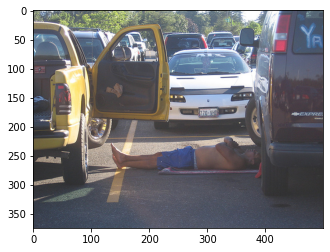

In [37]:
generate_caption("1067675215_7336a694d6.jpg")

---------------------Actual---------------------
startseq boy descends off the end of high diving board endseq
startseq child jumps off high diving board into the pool endseq
startseq kid jumps off the diving board and into the swimming pool below endseq
startseq little kid is jumping off high dive at the pool endseq
startseq the boy is jumping off high diving board into the pool endseq
--------------------Predicted--------------------
startseq boy dives into pool endseq


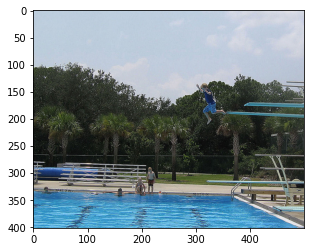

In [38]:
generate_caption("1057089366_ca83da0877.jpg")

---------------------Actual---------------------
startseq group of backpackers lay on the dry ground endseq
startseq group of hikers are resting on the ground in front of some mountains endseq
startseq people camp with the mountains in the background endseq
startseq several hikers rest with their gear in front of mountain endseq
startseq the group of hikers is resting in front of mountain endseq
--------------------Predicted--------------------
startseq group of hikers are resting on their motorcycles endseq


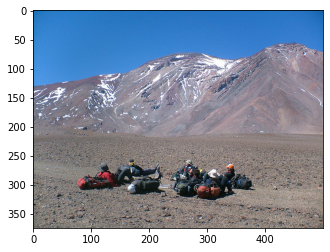

In [39]:
generate_caption("1093716555_801aacef79.jpg")

---------------------Actual---------------------
startseq boy lays on picnic table bench endseq
startseq child is laying down on wooden bench endseq
startseq child is on bench with arms stretched out endseq
startseq little boy in red shirt sitting on wooden picnic table bench endseq
startseq little boy lies down on picnic table bench endseq
--------------------Predicted--------------------
startseq two children are sitting on bench in front of window endseq


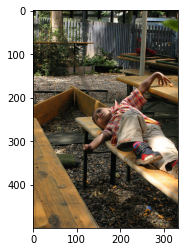

In [40]:
generate_caption("1204996216_71d7519d9a.jpg")

---------------------Actual---------------------
startseq dog in number six jersey is running through field endseq
startseq dog is leaping through the grass endseq
startseq dog is wearing red number and running through field of green grass while being chased by bird endseq
startseq white and tan dog leaps through the air endseq
startseq the dog in vest leaps in the air and there is bird flying endseq
--------------------Predicted--------------------
startseq dog leaps to catch yellow frisbee endseq


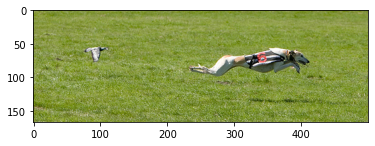

In [41]:
generate_caption("1240297429_c36ae0c58f.jpg")

---------------------Actual---------------------
startseq lady holds little girl who is trying to catch bubbles endseq
startseq woman is holding little girl who is trying to catch bubbles endseq
startseq woman with holding young girl playing with bubbles at picnic endseq
startseq "a young woman in blue shirt stands holding young girl in denim dress ." endseq
startseq there is woman holding her baby daughter while the daughter claps endseq
--------------------Predicted--------------------
startseq young girl in pink dress and pink hat is throwing camera endseq


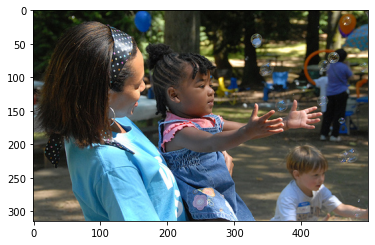

In [42]:
generate_caption("1237985362_dbafc59280.jpg")

---------------------Actual---------------------
startseq smiling girls in bathing suits sitting on the sand endseq
startseq group of friends smile for picture at the beach endseq
startseq group of young ladies in bikinis endseq
startseq the three girls in bathing suits are all smiles endseq
startseq the three girls sat on the beach endseq
--------------------Predicted--------------------
startseq three girls wearing bikinis are wearing bikinis endseq


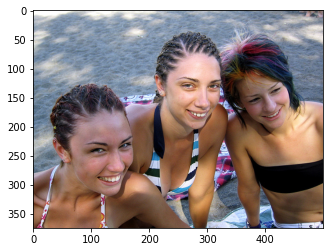

In [43]:
generate_caption("1244306891_8e78ae1620.jpg")

---------------------Actual---------------------
startseq black dog and brown dog are jumping up to catch red toy endseq
startseq black dog and brown dog play with red toy on courtyard endseq
startseq brown and black lab are outside and the black lab is catching toy in its mouth endseq
startseq black dog snaps at red and black object as brown dog lunges endseq
startseq the chocolate lab jumps too late to get the toy as the black lab captures it in the driveway endseq
--------------------Predicted--------------------
startseq brown dog snaps at large black dog endseq


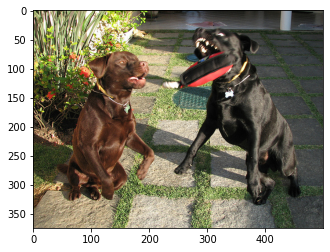

In [47]:
generate_caption("1030985833_b0902ea560.jpg")

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man in green coat is standing next to skyscraper with skyscraper in the background endseq


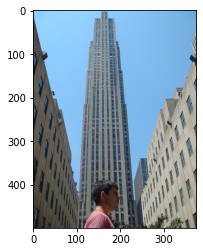

In [48]:
generate_caption("1032460886_4a598ed535.jpg")

---------------------Actual---------------------
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
--------------------Predicted--------------------
startseq man sits on bench reading book endseq


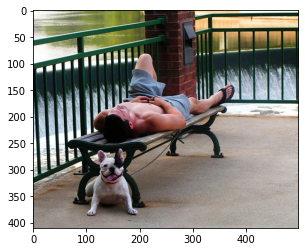

In [50]:
generate_caption("1003163366_44323f5815.jpg")